In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import matplotlib.pyplot as plt
import SolveLinSys
import time
from utilities import compute_derivatives_2d, find_nearest_value
from numba import njit

In [2]:
def false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_z.reshape(-1, 1, order='F'), B_y.reshape(-1, 1, order='F')])
    C = np.hstack([C_zz.reshape(-1, 1, order='F'), C_yy.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out

Equation:

\begin{align}
0 = \max_e \min_{h_2} \min_{\pi_j:\sum_j^J{\pi_j}=1} &-\delta \phi(y,z_2) + \delta\eta\log e + \xi_m \frac{(h_2)^2}{2} + \frac{\partial \phi}{\partial y}(y, z_2) e\\
&+ \left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\left[-\rho(z_2 - \mu_2) + \sqrt{z_2}\sigma_2 h_2\right] + \left[\frac{\partial^2 \phi}{\partial (z_2)^2}(y, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)\\
& + (\eta-1)\sum_{j}^J \pi_{j}\left(\frac{d}{d \tau}\Lambda_j(z_2 y)\left(z_2 e-y\rho(z_2-\mu_2)+ y\sqrt{z_2}\sigma_2h_2\right) + \frac{1}{2}\frac{d^2}{d\tau^2}\Lambda_j(z_2y)z_2y^2|\sigma_2|^2\right)\\
& + \xi_a \sum_{j}^J \pi_{j} \left(\log \pi_j - \log \pi_j^o\right)
\end{align}

where

\begin{equation}
\Lambda_j(\tau)=
\begin{cases}
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2, & \tau\leq \bar{\tau} \\
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2 + \frac{\lambda_{2,j}^+}{2}(\tau-\bar{\tau})^2, & \tau > \bar{\tau}
\end{cases}
\end{equation}

FOC of $\pi_j$ gives:
$$
\pi_j \propto \exp\left[-\frac{1}{\xi_a}(\eta-1)\left(\frac{d}{d \tau}\Lambda_j(z_2 y)\left(z_2 e-y\rho(z_2-\mu_2)+ y\sqrt{z_2}\sigma_2h_2\right) + \frac{1}{2}\frac{d^2}{d\tau^2}\Lambda_j(z_2y)z_2y^2|\sigma_2|^2\right)\right]\pi_j^o
$$

FOC of $h_2$ gives : 

\begin{align}
h_2^* = -\frac{\frac{\partial \phi}{\partial z_2}(y, z_2)\sqrt{z_2}\sigma_2 + (\eta-1)\sum_{j}^J \pi_j \frac{d}{d \tau}\Lambda_j(z_2 y)\left(y\sqrt{z_2}\sigma_2\right)}{\xi_m}
\end{align}

FOC of $e$ gives :

$$
e^* = -\frac{\delta \eta}{\frac{\partial \phi}{\partial y}(y, z_2) + (\eta-1)\sum_{j}^J\pi_j\frac{d}{d \tau}\Lambda_j(z_2 y)z_2}
$$

In [3]:
def false_transient(z_grid, y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    η, ξ_m, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o  = model_paras
    Δ_z = z_grid[1] - z_grid[0]
    Δ_y = y_grid[1] - y_grid[0]
    (z_mat, y_mat) = np.meshgrid(z_grid, y_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])
    if v0 is None:
        v0 = -δ*η*y_mat

    d_Λ = np.array([λ_1 + λ_2*y_mat*z_mat + 
                            λ_2p_j*(y_mat*z_mat>λ_bar)*(y_mat*z_mat-λ_bar) for λ_2p_j in λ_2p])
    dd_Λ = np.array([λ_2 + λ_2p_j*(y_mat*z_mat>λ_bar) for λ_2p_j in λ_2p])
    d_Λ_yz_sigma = d_Λ*y_mat*np.sqrt(z_mat)*σ_2
    d_Λ_z = d_Λ*z_mat
    mean_reversion = - y_mat*ρ*(z_mat-μ_2)
    std = np.sqrt(z_mat)*σ_2
    std_y = y_mat*std
    variance = z_mat*y_mat**2*σ_2**2

    π = np.ones_like(d_Λ)
    for i in range(π.shape[0]):
        π[i] = π_o[i]
    π_o = π.copy()
    h = - (η-1.) / ξ_m * np.sum(π*d_Λ_yz_sigma, axis=0)
    e = - δ*η / ((η-1)*np.sum(π*d_Λ_z, axis=0))
    
    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives_2d(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives_2d(v0, 0, 2, Δ_z)
        v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)

        temp = d_Λ*(z_mat*e + mean_reversion + std_y*h) + 0.5*dd_Λ*variance
        log_π_ratio = -(η-1.)*temp/ξ_a
        π_ratio = log_π_ratio - np.max(log_π_ratio, axis=0)
        π = np.exp(π_ratio) * π_o
        π = π/np.sum(π, axis=0)
        π[π<=0] = 1e-12
        
        h = - (v0_dz*std + (η-1)*np.sum(π*d_Λ_yz_sigma, axis=0)) / ξ_m
        e = - δ*η / (v0_dy + (η-1)*np.sum(π*d_Λ_z, axis=0))
        e[e<=0] = 1e-12

        A = np.ones_like(z_mat)*(-δ)
        B_z = -ρ*(z_mat - μ_2) + np.sqrt(z_mat)*σ_2*h
        B_y = e
        C_zz = z_mat*σ_2**2/2
        C_yy = np.zeros_like(z_mat)
        D = δ*η*np.log(e) + ξ_m*h**2/2 + (η-1)*np.sum(π*temp, axis=0)\
            + ξ_a*np.sum(π*(np.log(π)-np.log(π_o)), axis=0)
        res = false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_z*v0_dz + B_y*v0_dy + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    return v0, e, h, π

In [4]:
# Model parameters
η = .032
# ξ_m = .00256
# ξ_m = .05
ξ_m = 1000
ξ_a = .001
δ = .01
# Z process
μ_2 = 1.86/1000.
ρ = 0.9
σ_2 = np.sqrt(2*ρ/10416.29)/2
# Damage setting
λ_1 = 1.7675/10000
λ_2 = 0.0022*2
λ_bar = 2.

# three damage
# λ_2p = np.array([0., 0.0197*2, 0.3853*2])
# π_o = np.array([0.475, 0.475, 0.05])

# two damage
λ_2p = np.array([0., 0.0197*2])
π_o = np.array([0.5, 0.5])

pde_paras = (η, ξ_m, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o)

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

# Grid setting
n_z = 100
z_min = np.max([μ_2 - 3*np.sqrt(σ_2**2*μ_2/(2*ρ)), 1e-9])
z_max = μ_2 + 3*np.sqrt(σ_2**2*μ_2/(2*ρ))
z_grid = np.linspace(z_min, z_max, n_z)

n_y = 50
y_min = 1e-10
y_max = 2000.
y_grid = np.linspace(y_min, y_max, n_y)

In [5]:
ϕ_grid, e_grid, h_grid, π_grid = false_transient(z_grid, y_grid, model_paras=pde_paras,
                                         v0=None, ϵ=.5, tol=1e-8, max_iter=10_000)

Iteration 1: LHS Error: 0.028479014330648145; RHS Error 0.03401518153852737
Iteration 2: LHS Error: 0.02310190802248857; RHS Error 0.028206482929796405
Iteration 3: LHS Error: 0.018042213551503927; RHS Error 0.023251662041799022
Iteration 4: LHS Error: 0.013876217631198173; RHS Error 0.01824123438939193
Iteration 5: LHS Error: 0.010747029797440577; RHS Error 0.01414387548059776
Iteration 6: LHS Error: 0.008498985124499647; RHS Error 0.011076669739174018
Iteration 7: LHS Error: 0.006919809202963867; RHS Error 0.008877146055842985
Iteration 8: LHS Error: 0.0058224636249444295; RHS Error 0.0073335432551387
Iteration 9: LHS Error: 0.005063243070833945; RHS Error 0.006261428173596418
Iteration 10: LHS Error: 0.004538143359276825; RHS Error 0.005519797821720362
Iteration 11: LHS Error: 0.004174103946997354; RHS Error 0.005006860022196191
Iteration 12: LHS Error: 0.003920525622004956; RHS Error 0.004651197491678451
Iteration 13: LHS Error: 0.003742620732792634; RHS Error 0.004403384007711814


Iteration 106: LHS Error: 0.002284978860897624; RHS Error 0.002795097390920931
Iteration 107: LHS Error: 0.0022748714180538254; RHS Error 0.0027850100094909055
Iteration 108: LHS Error: 0.0022648030586589485; RHS Error 0.002774961397164731
Iteration 109: LHS Error: 0.0022547737316716; RHS Error 0.0027649515093005686
Iteration 110: LHS Error: 0.002244783420696228; RHS Error 0.0027549802985681465
Iteration 111: LHS Error: 0.00223483199191854; RHS Error 0.002745047789332447
Iteration 112: LHS Error: 0.0022249194244921; RHS Error 0.0027351537343601046
Iteration 113: LHS Error: 0.0022150456598977186; RHS Error 0.0027252982297990974
Iteration 114: LHS Error: 0.00220521063586121; RHS Error 0.002715481201007286
Iteration 115: LHS Error: 0.0021954142876807747; RHS Error 0.0027057025793876394
Iteration 116: LHS Error: 0.0021856565479625445; RHS Error 0.0026959623055645837
Iteration 117: LHS Error: 0.0021759373488112743; RHS Error 0.002686260312263121
Iteration 118: LHS Error: 0.00216625659967983

Iteration 210: LHS Error: 0.0014275251530659894; RHS Error 0.0019387758957919166
Iteration 211: LHS Error: 0.0014209908084661382; RHS Error 0.0019322471332265528
Iteration 212: LHS Error: 0.0014144851191513208; RHS Error 0.0019257470635469995
Iteration 213: LHS Error: 0.0014080079882956564; RHS Error 0.0019192755420500349
Iteration 214: LHS Error: 0.001401559311619005; RHS Error 0.001912832436034427
Iteration 215: LHS Error: 0.0013951389826796223; RHS Error 0.001906417634803148
Iteration 216: LHS Error: 0.0013887468927582525; RHS Error 0.00190003102026845
Iteration 217: LHS Error: 0.0013823829331602866; RHS Error 0.001893672488198661
Iteration 218: LHS Error: 0.0013760476254023324; RHS Error 0.0018873418859700133
Iteration 219: LHS Error: 0.0013697396438479004; RHS Error 0.0018810485521951678
Iteration 220: LHS Error: 0.0013634590953703896; RHS Error 0.0018747593110207753
Iteration 221: LHS Error: 0.001357206389403398; RHS Error 0.0018685151278897208
Iteration 222: LHS Error: 0.0013509

Iteration 312: LHS Error: 0.000890868034126413; RHS Error 0.0014024970086999253
Iteration 313: LHS Error: 0.0008867337556841548; RHS Error 0.0013983662273871697
Iteration 314: LHS Error: 0.0008825879418725702; RHS Error 0.0013942541266495842
Iteration 315: LHS Error: 0.0008785917641054297; RHS Error 0.0013901684874837866
Iteration 316: LHS Error: 0.0008744821789921087; RHS Error 0.001386081301303084
Iteration 317: LHS Error: 0.0008704046251823971; RHS Error 0.0013820274935784221
Iteration 318: LHS Error: 0.0008663551608361075; RHS Error 0.0013779905233941916
Iteration 319: LHS Error: 0.0008623287584774708; RHS Error 0.0013739713381913238
Iteration 320: LHS Error: 0.0008583229231513556; RHS Error 0.001369970262098688
Iteration 321: LHS Error: 0.0008543363325279607; RHS Error 0.0013659873505637923
Iteration 322: LHS Error: 0.0008503684732037442; RHS Error 0.0013620225540444397
Iteration 323: LHS Error: 0.0008463890970362709; RHS Error 0.0013580757536250584
Iteration 324: LHS Error: 0.000

Iteration 415: LHS Error: 0.0005507562630568952; RHS Error 0.0010625656415247514
Iteration 416: LHS Error: 0.0005481822693857996; RHS Error 0.0010599928350394291
Iteration 417: LHS Error: 0.0005456201620572809; RHS Error 0.0010574319127721749
Iteration 418: LHS Error: 0.0005430698935302569; RHS Error 0.0010548828235726893
Iteration 419: LHS Error: 0.00054053140971555; RHS Error 0.0010523455152433928
Iteration 420: LHS Error: 0.0005380067211651074; RHS Error 0.0010498199294144209
Iteration 421: LHS Error: 0.000535488355120961; RHS Error 0.0010473051947544262
Iteration 422: LHS Error: 0.0005329855594657928; RHS Error 0.0010448043042954186
Iteration 423: LHS Error: 0.0005304940278960668; RHS Error 0.0010423132026851495
Iteration 424: LHS Error: 0.0005280138290166825; RHS Error 0.0010398338259389045
Iteration 425: LHS Error: 0.0005255471603957673; RHS Error 0.0010373660135636134
Iteration 426: LHS Error: 0.0005230862981597806; RHS Error 0.0010349087690950248
Iteration 427: LHS Error: 0.000

Iteration 517: LHS Error: 0.00034115834031944736; RHS Error 0.0008530583412981671
Iteration 518: LHS Error: 0.00033955681251263137; RHS Error 0.0008514575617095468
Iteration 519: LHS Error: 0.0003379627678277153; RHS Error 0.0008498642112369156
Iteration 520: LHS Error: 0.0003363761617276584; RHS Error 0.0008482782532943378
Iteration 521: LHS Error: 0.0003347969651628091; RHS Error 0.0008466996855660269
Iteration 522: LHS Error: 0.0003332251103640438; RHS Error 0.0008451284853663796
Iteration 523: LHS Error: 0.0003316605830132602; RHS Error 0.0008435645838262701
Iteration 524: LHS Error: 0.0003301033433222855; RHS Error 0.000842007980069566
Iteration 525: LHS Error: 0.00032855338927473277; RHS Error 0.0008404586196704492
Iteration 526: LHS Error: 0.00032701063233808725; RHS Error 0.0008389165072443944
Iteration 527: LHS Error: 0.00032547508445457396; RHS Error 0.0008373815545313426
Iteration 528: LHS Error: 0.0003239466862043905; RHS Error 0.0008358537770318808
Iteration 529: LHS Error

Iteration 618: LHS Error: 0.00021195184776745535; RHS Error 0.0007239018974032341
Iteration 619: LHS Error: 0.00021095362674006246; RHS Error 0.0007229041774798259
Iteration 620: LHS Error: 0.00020996040516774173; RHS Error 0.0007219114393613724
Iteration 621: LHS Error: 0.00020897179081469375; RHS Error 0.0007209231310475114
Iteration 622: LHS Error: 0.00020798780075059753; RHS Error 0.0007199394627803307
Iteration 623: LHS Error: 0.000207008403713127; RHS Error 0.0007189604194018026
Iteration 624: LHS Error: 0.00020603375222982834; RHS Error 0.0007179859649761589
Iteration 625: LHS Error: 0.00020506324765467987; RHS Error 0.000717015954490488
Iteration 626: LHS Error: 0.0002040975635737574; RHS Error 0.0007160508198841009
Iteration 627: LHS Error: 0.0002031366328754114; RHS Error 0.0007150899434950481
Iteration 628: LHS Error: 0.00020217969749070086; RHS Error 0.0007141334609347266
Iteration 629: LHS Error: 0.0002012277148841779; RHS Error 0.0007131818152385089
Iteration 630: LHS Err

Iteration 720: LHS Error: 0.00013089474915162214; RHS Error 0.0006428739944225603
Iteration 721: LHS Error: 0.0001302764463970707; RHS Error 0.0006422564801202568
Iteration 722: LHS Error: 0.00012966253245871862; RHS Error 0.0006416419665930193
Iteration 723: LHS Error: 0.00012905045123701164; RHS Error 0.0006410301002347935
Iteration 724: LHS Error: 0.00012844130170641677; RHS Error 0.0006404212976725485
Iteration 725: LHS Error: 0.00012783506093461128; RHS Error 0.000639815333527638
Iteration 726: LHS Error: 0.0001272316958988995; RHS Error 0.0006392122025645763
Iteration 727: LHS Error: 0.00012663117993261253; RHS Error 0.0006386118939637406
Iteration 728: LHS Error: 0.0001260334912505101; RHS Error 0.0006380144180323163
Iteration 729: LHS Error: 0.00012543861067260131; RHS Error 0.0006374197383589159
Iteration 730: LHS Error: 0.00012484653103994603; RHS Error 0.000636827870204297
Iteration 731: LHS Error: 0.0001242566824506408; RHS Error 0.0006362387669599928
Iteration 732: LHS Err

Iteration 822: LHS Error: 8.075553495001664e-05; RHS Error 0.0005927514017390542
Iteration 823: LHS Error: 8.037372919322827e-05; RHS Error 0.0005923697265359518
Iteration 824: LHS Error: 7.999372321565446e-05; RHS Error 0.0005919898430463283
Iteration 825: LHS Error: 7.961550501200954e-05; RHS Error 0.0005916117487880027
Iteration 826: LHS Error: 7.92390707446966e-05; RHS Error 0.0005912354440737802
Iteration 827: LHS Error: 7.886441127258337e-05; RHS Error 0.0005908609106811957
Iteration 828: LHS Error: 7.849151446848168e-05; RHS Error 0.0005904881328592862
Iteration 829: LHS Error: 7.812037632648483e-05; RHS Error 0.0005901171237062269
Iteration 830: LHS Error: 7.775098717055506e-05; RHS Error 0.0005897478550957666
Iteration 831: LHS Error: 7.738333833673394e-05; RHS Error 0.0005893803324641608
Iteration 832: LHS Error: 7.701742222865349e-05; RHS Error 0.0005890145383940157
Iteration 833: LHS Error: 7.665322977201683e-05; RHS Error 0.0005886504627806918
Iteration 834: LHS Error: 7.6

Iteration 924: LHS Error: 4.978178219183782e-05; RHS Error 0.0005617878788807887
Iteration 925: LHS Error: 4.954605380236288e-05; RHS Error 0.0005615522187853994
Iteration 926: LHS Error: 4.931144177655611e-05; RHS Error 0.0005613176882106816
Iteration 927: LHS Error: 4.907780390484007e-05; RHS Error 0.000561084258540491
Iteration 928: LHS Error: 4.8845302379918465e-05; RHS Error 0.0005608515880251297
Iteration 929: LHS Error: 4.861428199376405e-05; RHS Error 0.0005606203262284518
Iteration 930: LHS Error: 4.83840120333312e-05; RHS Error 0.0005603909207830896
Iteration 931: LHS Error: 4.81548585673508e-05; RHS Error 0.000560161596668142
Iteration 932: LHS Error: 4.792656293317599e-05; RHS Error 0.0005599335118628215
Iteration 933: LHS Error: 4.769989485353676e-05; RHS Error 0.0005597060737154297
Iteration 934: LHS Error: 4.7473888650673146e-05; RHS Error 0.0005594810864525956
Iteration 935: LHS Error: 4.724888044904674e-05; RHS Error 0.0005592558998186933
Iteration 936: LHS Error: 4.70

Iteration 1025: LHS Error: 3.0812262891366515e-05; RHS Error 0.0005428244484255648
Iteration 1026: LHS Error: 3.0666094147369094e-05; RHS Error 0.0005426785000522405
Iteration 1027: LHS Error: 3.052075026199752e-05; RHS Error 0.000542532736678078
Iteration 1028: LHS Error: 3.0375951266092827e-05; RHS Error 0.0005423885251108623
Iteration 1029: LHS Error: 3.0231949823100734e-05; RHS Error 0.0005422440937726744
Iteration 1030: LHS Error: 3.0088619062729194e-05; RHS Error 0.0005421010933001277
Iteration 1031: LHS Error: 2.9945938797792948e-05; RHS Error 0.000541958519384475
Iteration 1032: LHS Error: 2.980389845164133e-05; RHS Error 0.0005418164674678427
Iteration 1033: LHS Error: 2.966260190651049e-05; RHS Error 0.0005416750262411466
Iteration 1034: LHS Error: 2.9521750403826985e-05; RHS Error 0.000541534580260232
Iteration 1035: LHS Error: 2.938191202295215e-05; RHS Error 0.0005413939224406458
Iteration 1036: LHS Error: 2.9242547702201804e-05; RHS Error 0.0005412555151220258
Iteration 1

Iteration 1125: LHS Error: 1.9150037934734243e-05; RHS Error 0.0005311659167265628
Iteration 1126: LHS Error: 1.9059122787101757e-05; RHS Error 0.0005310750098447906
Iteration 1127: LHS Error: 1.896863937744797e-05; RHS Error 0.0005309845533440147
Iteration 1128: LHS Error: 1.8878573841751844e-05; RHS Error 0.0005308945337587009
Iteration 1129: LHS Error: 1.8788952452553076e-05; RHS Error 0.0005308048947830074
Iteration 1130: LHS Error: 1.869974939072705e-05; RHS Error 0.0005307157535154039
Iteration 1131: LHS Error: 1.861096720823241e-05; RHS Error 0.000530626995916085
Iteration 1132: LHS Error: 1.852259588197569e-05; RHS Error 0.0005305386542128754
Iteration 1133: LHS Error: 1.8434660775001888e-05; RHS Error 0.0005304507120766702
Iteration 1134: LHS Error: 1.834712563808516e-05; RHS Error 0.0005303632483458914
Iteration 1135: LHS Error: 1.826001367910557e-05; RHS Error 0.0005302761288310323
Iteration 1136: LHS Error: 1.8173322572812012e-05; RHS Error 0.0005301894673673258
Iteration 1

Iteration 1225: LHS Error: 1.1895441696330167e-05; RHS Error 0.0005239134501645662
Iteration 1226: LHS Error: 1.1838903048566607e-05; RHS Error 0.0005238569192877116
Iteration 1227: LHS Error: 1.1782633067447534e-05; RHS Error 0.0005238006567688178
Iteration 1228: LHS Error: 1.1726630942066052e-05; RHS Error 0.0005237446663744691
Iteration 1229: LHS Error: 1.1670856892909143e-05; RHS Error 0.0005236889504107792
Iteration 1230: LHS Error: 1.1615390766994693e-05; RHS Error 0.0005236333737680884
Iteration 1231: LHS Error: 1.1560185822601099e-05; RHS Error 0.0005235782393590571
Iteration 1232: LHS Error: 1.1505239775999598e-05; RHS Error 0.0005235233277211329
Iteration 1233: LHS Error: 1.1450553938807673e-05; RHS Error 0.0005234686568547156
Iteration 1234: LHS Error: 1.139612690681524e-05; RHS Error 0.0005234142493986405
Iteration 1235: LHS Error: 1.134195760466028e-05; RHS Error 0.0005233601011388408
Iteration 1236: LHS Error: 1.128804557759544e-05; RHS Error 0.0005233062025388271
Iterati

Iteration 1325: LHS Error: 7.394813365202424e-06; RHS Error 0.0005194016481752939
Iteration 1326: LHS Error: 7.353680773425353e-06; RHS Error 0.0005193692731062585
Iteration 1327: LHS Error: 7.317721452348991e-06; RHS Error 0.0005193326185451222
Iteration 1328: LHS Error: 7.297519119431328e-06; RHS Error 0.000519302100604177
Iteration 1329: LHS Error: 7.2469648668693765e-06; RHS Error 0.0005192636102732059
Iteration 1330: LHS Error: 7.230187401896515e-06; RHS Error 0.0005192319004421533
Iteration 1331: LHS Error: 7.1878431440186574e-06; RHS Error 0.0005191932148967335
Iteration 1332: LHS Error: 7.148156566882946e-06; RHS Error 0.0005191619248700319
Iteration 1333: LHS Error: 7.110557726619504e-06; RHS Error 0.0005191275664221812
Iteration 1334: LHS Error: 7.07454787152173e-06; RHS Error 0.0005190960905314609
Iteration 1335: LHS Error: 7.041324789902603e-06; RHS Error 0.0005190605878142573
Iteration 1336: LHS Error: 7.007248720380943e-06; RHS Error 0.0005190274552996713
Iteration 1337: 

Iteration 1425: LHS Error: 4.582981833811672e-06; RHS Error 0.0005166028662903083
Iteration 1426: LHS Error: 4.561123027491121e-06; RHS Error 0.0005165809742876809
Iteration 1427: LHS Error: 4.539907332734572e-06; RHS Error 0.0005165592499099536
Iteration 1428: LHS Error: 4.5181793413284765e-06; RHS Error 0.0005165360088609586
Iteration 1429: LHS Error: 4.498079085646367e-06; RHS Error 0.0005165157417459862
Iteration 1430: LHS Error: 4.475326898401022e-06; RHS Error 0.0005164965251296672
Iteration 1431: LHS Error: 4.455131102476528e-06; RHS Error 0.0005164726017261659
Iteration 1432: LHS Error: 4.433080458499106e-06; RHS Error 0.0005164537853946383
Iteration 1433: LHS Error: 4.4117159188061805e-06; RHS Error 0.0005164318106098756
Iteration 1434: LHS Error: 4.390593036252e-06; RHS Error 0.0005164088662426985
Iteration 1435: LHS Error: 4.369645235424713e-06; RHS Error 0.0005163890023320433
Iteration 1436: LHS Error: 4.34892419254318e-06; RHS Error 0.0005163686769461065
Iteration 1437: LH

Iteration 1527: LHS Error: 2.816463986921036e-06; RHS Error 0.0005148368399129979
Iteration 1528: LHS Error: 2.803036393661529e-06; RHS Error 0.0005148234180141764
Iteration 1529: LHS Error: 2.7896732461840656e-06; RHS Error 0.0005148100627022992
Iteration 1530: LHS Error: 2.776372289403639e-06; RHS Error 0.0005147967673753279
Iteration 1531: LHS Error: 2.76313547864504e-06; RHS Error 0.0005147835436478329
Iteration 1532: LHS Error: 2.7499624255522548e-06; RHS Error 0.0005147703770637252
Iteration 1533: LHS Error: 2.7368515342907074e-06; RHS Error 0.000514757267985666
Iteration 1534: LHS Error: 2.7238037760835e-06; RHS Error 0.0005147442224776033
Iteration 1535: LHS Error: 2.710817105233687e-06; RHS Error 0.0005147312430762649
Iteration 1536: LHS Error: 2.6978928446830253e-06; RHS Error 0.0005147183215201828
Iteration 1537: LHS Error: 2.685030783933229e-06; RHS Error 0.0005147054636801887
Iteration 1538: LHS Error: 2.6722283759106347e-06; RHS Error 0.0005146926663619628
Iteration 1539:

Iteration 1628: LHS Error: 1.7377930627837657e-06; RHS Error 0.0005137587483637421
Iteration 1629: LHS Error: 1.7295609522349764e-06; RHS Error 0.0005137500102311982
Iteration 1630: LHS Error: 1.7212144145517527e-06; RHS Error 0.0005137421561671809
Iteration 1631: LHS Error: 1.7130151723776521e-06; RHS Error 0.000513733786224449
Iteration 1632: LHS Error: 1.7048447231715613e-06; RHS Error 0.0005137255732748924
Iteration 1633: LHS Error: 1.6967556830671526e-06; RHS Error 0.0005137174375294887
Iteration 1634: LHS Error: 1.6886487403944273e-06; RHS Error 0.0005137090666769775
Iteration 1635: LHS Error: 1.680536027226509e-06; RHS Error 0.0005137014497683043
Iteration 1636: LHS Error: 1.6725292033559214e-06; RHS Error 0.0005136933150542353
Iteration 1637: LHS Error: 1.6645953500038502e-06; RHS Error 0.0005136852910966119
Iteration 1638: LHS Error: 1.6566421843222656e-06; RHS Error 0.0005136770772741286
Iteration 1639: LHS Error: 1.648685385102766e-06; RHS Error 0.0005136696042498945
Iterati

Iteration 1730: LHS Error: 1.066570371799358e-06; RHS Error 0.0005130874950355427
Iteration 1731: LHS Error: 1.0614717098622606e-06; RHS Error 0.0005130823639433735
Iteration 1732: LHS Error: 1.0564019956582626e-06; RHS Error 0.0005130773209586631
Iteration 1733: LHS Error: 1.0513581301108132e-06; RHS Error 0.0005130722715201153
Iteration 1734: LHS Error: 1.0463319908282642e-06; RHS Error 0.000513067225723314
Iteration 1735: LHS Error: 1.0413348370263975e-06; RHS Error 0.0005130622621973488
Iteration 1736: LHS Error: 1.0363605742469417e-06; RHS Error 0.0005130572749526552
Iteration 1737: LHS Error: 1.0314103737751878e-06; RHS Error 0.0005130523305109519
Iteration 1738: LHS Error: 1.0264827605688254e-06; RHS Error 0.0005130474056270276
Iteration 1739: LHS Error: 1.0215789405521036e-06; RHS Error 0.0005130425045353423
Iteration 1740: LHS Error: 1.0166987522985949e-06; RHS Error 0.0005130376257463931
Iteration 1741: LHS Error: 1.0118420916693793e-06; RHS Error 0.0005130327613789912
Iterat

Iteration 1832: LHS Error: 6.563811982829293e-07; RHS Error 0.0005126737639400206
Iteration 1833: LHS Error: 6.520763276007813e-07; RHS Error 0.0005126738642171544
Iteration 1834: LHS Error: 6.501629656874286e-07; RHS Error 0.0005126675070219397
Iteration 1835: LHS Error: 6.45236753138434e-07; RHS Error 0.0005126676675139205
Iteration 1836: LHS Error: 6.424969221097143e-07; RHS Error 0.0005126626702821185
Iteration 1837: LHS Error: 6.405352590554969e-07; RHS Error 0.0005126589860576097
Iteration 1838: LHS Error: 6.366788287692771e-07; RHS Error 0.0005126581590748427
Iteration 1839: LHS Error: 6.347969474518322e-07; RHS Error 0.0005126522041113482
Iteration 1840: LHS Error: 6.305823159191704e-07; RHS Error 0.0005126523971778416
Iteration 1841: LHS Error: 6.287149849626417e-07; RHS Error 0.0005126461719741002
Iteration 1842: LHS Error: 6.23960633827636e-07; RHS Error 0.0005126463399582962
Iteration 1843: LHS Error: 6.211849192805374e-07; RHS Error 0.0005126414954379696
Iteration 1844: LH

Iteration 1934: LHS Error: 4.0134652379286706e-07; RHS Error 0.0005124223060547634
Iteration 1935: LHS Error: 3.994546824426237e-07; RHS Error 0.0005124204557647657
Iteration 1936: LHS Error: 3.975198890060483e-07; RHS Error 0.0005124184724585035
Iteration 1937: LHS Error: 3.9564317755313994e-07; RHS Error 0.0005124166629293936
Iteration 1938: LHS Error: 3.937154937627696e-07; RHS Error 0.000512414671606086
Iteration 1939: LHS Error: 3.9185807376718174e-07; RHS Error 0.0005124128701530159
Iteration 1940: LHS Error: 3.899693343800692e-07; RHS Error 0.0005124109324359666
Iteration 1941: LHS Error: 3.8812239289143236e-07; RHS Error 0.0005124090960356362
Iteration 1942: LHS Error: 3.862317736746945e-07; RHS Error 0.0005124071976807532
Iteration 1943: LHS Error: 3.843878992881855e-07; RHS Error 0.0005124054167181744
Iteration 1944: LHS Error: 3.8254302148210684e-07; RHS Error 0.0005124035695278154
Iteration 1945: LHS Error: 3.8073587793618913e-07; RHS Error 0.0005124017411800297
Iteration 1

Iteration 2036: LHS Error: 2.459500758611455e-07; RHS Error 0.0005122670519603842
Iteration 2037: LHS Error: 2.4478789883985996e-07; RHS Error 0.0005122658725241619
Iteration 2038: LHS Error: 2.435981045767477e-07; RHS Error 0.0005122646618368754
Iteration 2039: LHS Error: 2.424443292792233e-07; RHS Error 0.0005122635400841985
Iteration 2040: LHS Error: 2.412682664765242e-07; RHS Error 0.0005122623388339048
Iteration 2041: LHS Error: 2.4012725918787226e-07; RHS Error 0.0005122612227814877
Iteration 2042: LHS Error: 2.389642950184623e-07; RHS Error 0.0005122600361648841
Iteration 2043: LHS Error: 2.3781170543912822e-07; RHS Error 0.0005122589178637726
Iteration 2044: LHS Error: 2.366869265024718e-07; RHS Error 0.0005122577975046963
Iteration 2045: LHS Error: 2.395795881682261e-07; RHS Error 0.0005122566674867976
Iteration 2046: LHS Error: 2.3604065280125042e-07; RHS Error 0.000512258903775327
Iteration 2047: LHS Error: 2.3450366781752052e-07; RHS Error 0.0005122557939620936
Iteration 20

Iteration 2139: LHS Error: 1.5132921538096866e-07; RHS Error 0.0005121722966864861
Iteration 2140: LHS Error: 1.502911364248405e-07; RHS Error 0.0005121696584217197
Iteration 2141: LHS Error: 1.49354150824621e-07; RHS Error 0.0005121696934469594
Iteration 2142: LHS Error: 1.4837819950486164e-07; RHS Error 0.0005121691751244009
Iteration 2143: LHS Error: 1.4852180374447244e-07; RHS Error 0.000512168456890276
Iteration 2144: LHS Error: 1.4791966962413028e-07; RHS Error 0.0005121686245572049
Iteration 2145: LHS Error: 1.4680910842557182e-07; RHS Error 0.0005121662013881784
Iteration 2146: LHS Error: 1.4621362032229968e-07; RHS Error 0.0005121662376981334
Iteration 2147: LHS Error: 1.462247749550727e-07; RHS Error 0.0005121663774857454
Iteration 2148: LHS Error: 1.4498259526263269e-07; RHS Error 0.0005121642949922484
Iteration 2149: LHS Error: 1.4409525794789602e-07; RHS Error 0.0005121642583609531
Iteration 2150: LHS Error: 1.4427174810371923e-07; RHS Error 0.0005121642873133214
Iteration

Iteration 2241: LHS Error: 9.255815225372999e-08; RHS Error 0.0005121121123638286
Iteration 2242: LHS Error: 9.198324146808545e-08; RHS Error 0.0005121118363559246
Iteration 2243: LHS Error: 9.624369456950888e-08; RHS Error 0.0005121116967715528
Iteration 2244: LHS Error: 9.184471183587561e-08; RHS Error 0.0005121132491258812
Iteration 2245: LHS Error: 1.6738904107249652e-07; RHS Error 0.0005121121947149893
Iteration 2246: LHS Error: 1.3408927479474642e-07; RHS Error 0.0005121091219070159
Iteration 2247: LHS Error: 1.0916464643351276e-07; RHS Error 0.0005121102260639693
Iteration 2248: LHS Error: 1.011691319607877e-07; RHS Error 0.0005121096623387986
Iteration 2249: LHS Error: 9.175546744621954e-08; RHS Error 0.0005121092709274994
Iteration 2250: LHS Error: 8.946108209784143e-08; RHS Error 0.0005121088584400385
Iteration 2251: LHS Error: 8.827969733005148e-08; RHS Error 0.0005121078636183968
Iteration 2252: LHS Error: 8.767427939204708e-08; RHS Error 0.0005121076126074417
Iteration 225

Iteration 2342: LHS Error: 1.6643201994348544e-07; RHS Error 0.0005120754588023996
Iteration 2343: LHS Error: 5.462018970447957e-08; RHS Error 0.0005120763722776048
Iteration 2344: LHS Error: 1.6490628440557487e-07; RHS Error 0.0005120749628085425
Iteration 2345: LHS Error: 5.4116605863185896e-08; RHS Error 0.0005120758587128307
Iteration 2346: LHS Error: 1.6336037034214712e-07; RHS Error 0.0005120744692894627
Iteration 2347: LHS Error: 5.361141930393387e-08; RHS Error 0.0005120753508960074
Iteration 2348: LHS Error: 1.618841227735146e-07; RHS Error 0.0005120739799671092
Iteration 2349: LHS Error: 5.311872142144125e-08; RHS Error 0.0005120748490512472
Iteration 2350: LHS Error: 1.6032825667089412e-07; RHS Error 0.0005120734887321468
Iteration 2351: LHS Error: 5.261856417249078e-08; RHS Error 0.0005120743399206693
Iteration 2352: LHS Error: 1.5890450888456087e-07; RHS Error 0.0005120730144551958
Iteration 2353: LHS Error: 5.213795595260251e-08; RHS Error 0.000512073856108429
Iteration 2

Iteration 2443: LHS Error: 1.399925977363381e-07; RHS Error 0.000512054645730585
Iteration 2444: LHS Error: 4.076743143066608e-08; RHS Error 0.0005120538804897282
Iteration 2445: LHS Error: 3.344183374665022e-08; RHS Error 0.0005120517507137406
Iteration 2446: LHS Error: 3.325008401944274e-08; RHS Error 0.0005120543025516414
Iteration 2447: LHS Error: 3.30531513270671e-08; RHS Error 0.0005120532238504019
Iteration 2448: LHS Error: 3.2982703235262534e-08; RHS Error 0.000512053886232107
Iteration 2449: LHS Error: 3.2801878546706575e-08; RHS Error 0.0005120540789206734
Iteration 2450: LHS Error: 3.237184431625906e-08; RHS Error 0.0005120538742471939
Iteration 2451: LHS Error: 2.5108252743599735e-07; RHS Error 0.0005120534432556667
Iteration 2452: LHS Error: 3.557635430695427e-08; RHS Error 0.0005120528302394248
Iteration 2453: LHS Error: 3.313543039951128e-08; RHS Error 0.0005120496823258422
Iteration 2454: LHS Error: 3.080535071475765e-08; RHS Error 0.0005120538590934476
Iteration 2455: 

Iteration 2545: LHS Error: 1.9922838490060713e-08; RHS Error 0.0005120451239986959
Iteration 2546: LHS Error: 1.9958867447655848e-08; RHS Error 0.0005120403781662466
Iteration 2547: LHS Error: 1.98291063568945e-08; RHS Error 0.0005120406478174716
Iteration 2548: LHS Error: 2.1275261685715918e-07; RHS Error 0.0005120409773108209
Iteration 2549: LHS Error: 2.7006397340656463e-08; RHS Error 0.0005120387840778923
Iteration 2550: LHS Error: 2.204976734532238e-08; RHS Error 0.0005120402269294944
Iteration 2551: LHS Error: 1.9797095962559297e-08; RHS Error 0.000512042754302347
Iteration 2552: LHS Error: 1.980668473677838e-08; RHS Error 0.0005120401867600086
Iteration 2553: LHS Error: 1.970855789679149e-08; RHS Error 0.0005120406142795075
Iteration 2554: LHS Error: 1.978035291116953e-08; RHS Error 0.0005120408789253128
Iteration 2555: LHS Error: 1.9508945126034405e-08; RHS Error 0.0005120408791259787
Iteration 2556: LHS Error: 1.9362363712360775e-08; RHS Error 0.0005120406310869172
Iteration 2

Iteration 2645: LHS Error: 1.5944919606880603e-08; RHS Error 0.0005120345364466802
Iteration 2646: LHS Error: 1.2782884084572288e-08; RHS Error 0.0005120364452623344
Iteration 2647: LHS Error: 1.2821053552158901e-08; RHS Error 0.0005120329739593532
Iteration 2648: LHS Error: 1.2717281450136397e-08; RHS Error 0.0005120330536425438
Iteration 2649: LHS Error: 1.2709880259365036e-08; RHS Error 0.000512033795397257
Iteration 2650: LHS Error: 1.2678320615577832e-08; RHS Error 0.0005120338482817385
Iteration 2651: LHS Error: 1.254323400701196e-08; RHS Error 0.0005120338241512423
Iteration 2652: LHS Error: 1.8008410629377636e-07; RHS Error 0.0005120337231267688
Iteration 2653: LHS Error: 2.3658450087893357e-08; RHS Error 0.0005120273293982083
Iteration 2654: LHS Error: 1.308107533404268e-08; RHS Error 0.0005120380655511472
Iteration 2655: LHS Error: 1.2852883646274904e-08; RHS Error 0.0005120323254707085
Iteration 2656: LHS Error: 1.275992200788778e-08; RHS Error 0.0005120327118172049
Iteratio

In [7]:
np.save('y.npy', y_grid)
np.save('pi.npy', π_grid)

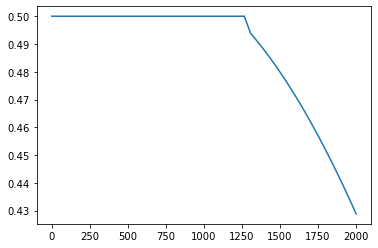

In [179]:
plt.plot(y_grid, π_grid[0,25])

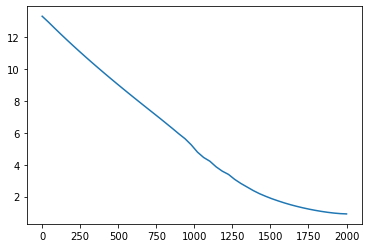

In [162]:
plt.plot(y_grid, e_grid[25])

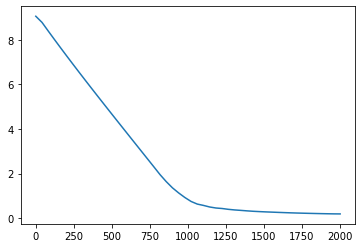

In [156]:
plt.plot(y_grid, e_grid[25])

In [150]:
@njit(parallel=True)
def simulate_emission(e_grid, y_grid, y_start=290, z_loc=25, T=100):
    Et = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid[z_loc])
        y_start = y_start + Et[i]
    return Et


@njit(parallel=True)
def simulate_h(e_grid, y_grid, h_grid, y_start=290, z_loc=25, T=100):
    ht = np.zeros(T+1)
    for i in range(T+1):
        e = np.interp(y_start, y_grid, e_grid[z_loc])
        ht[i] = np.interp(y_start, y_grid, h_grid[z_loc])
        y_start = y_start + e
    return ht


@njit(parallel=True)
def simulate_π(e_grid, y_grid, π_grid, y_start=290, z_loc=25, T=100):
    πt = np.zeros(T+1)
    for i in range(T+1):
        e = np.interp(y_start, y_grid, e_grid[z_loc])
        πt[i] = np.interp(y_start, y_grid, π_grid[0, z_loc])
        y_start = y_start + e
    return πt


@njit(parallel=True)
def simulate_damage(e_grid, y_grid, λ_1, λ_2, λ_2p, λ_bar, y_start=290, z_loc=25, T=100):
    nt = np.zeros(T+1)
    for i in range(T+1):
        e = np.interp(y_start, y_grid, e_grid[z_loc])
        y_start = y_start + e
        nt[i] = 1./np.exp(λ_1*μ_2*y_start + 0.5*λ_2*(μ_2*y_start)**2 + 0.5*λ_2p*(μ_2*y_start-λ_bar)**2*(μ_2*y_start>λ_bar))
    return nt


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

In [153]:
T = 100
Et = simulate_emission(e_grid, y_grid, y_start=290, z_loc=25, T=T)
ht = simulate_h(e_grid, y_grid, h_grid, y_start=290, z_loc=25, T=T)
πt = simulate_π(e_grid, y_grid, π_grid, y_start=290, z_loc=25, T=T)
nt_low = simulate_damage(e_grid, y_grid, λ_1, λ_2, λ_2p[0], λ_bar, y_start=290, z_loc=25, T=100)
nt_high = simulate_damage(e_grid, y_grid, λ_1, λ_2, λ_2p[1], λ_bar, y_start=290, z_loc=25, T=100)

Text(0.5, 0, 'Year')

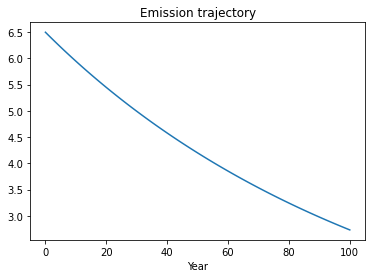

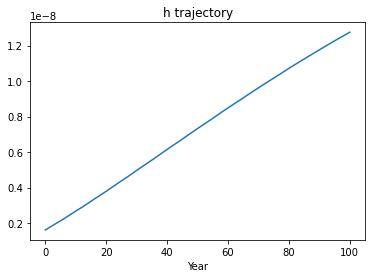

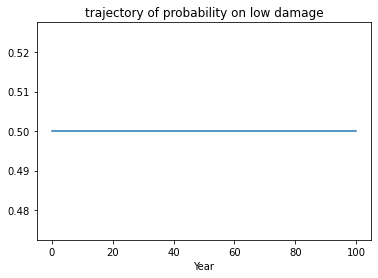

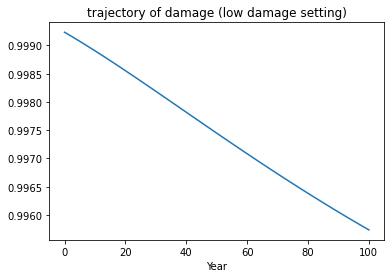

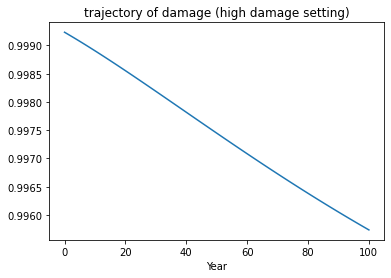

In [154]:
plt.figure()
plt.title('Emission trajectory')
plt.plot(Et)
plt.xlabel('Year')
plt.figure()
plt.title('h trajectory')
plt.plot(ht)
plt.xlabel('Year')
plt.figure()
plt.title('trajectory of probability on low damage')
plt.plot(πt)
plt.xlabel('Year')
plt.figure()
plt.title('trajectory of damage (low damage setting)')
plt.plot(nt_low)
plt.xlabel('Year')
plt.figure()
plt.title('trajectory of damage (high damage setting)')
plt.plot(nt_high)
plt.xlabel('Year')

In [ ]:
T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [ ]:
SCCt = η*(α-ioverk)*Kt/((1.-η)*Et)
# SCCt = η*(0.025)*Kt/((1.-η)*Et)

In [ ]:
plt.plot(SCCt[:21]*1000)
plt.ylim(0, None)
plt.title('Figure 1: Social cost of carbon')
plt.xlabel('Year')
# plt.savefig('figure_1.pdf')

In [ ]:
import pickle
with open('scc_bhh.pkl', 'rb') as f:
    scc_bhh = pickle.load(f)
with open('emission.pkl', 'rb') as f:
    emission_bbh = pickle.load(f)

In [ ]:
plt.plot(scc_bhh[0]['x'], scc_bhh[0]['y'])

In [ ]:
scc_low = np.array([scc_bhh[0]['y'][4*i] for i in range(21)])

### SCC formula

$$
SCC = \frac{\eta\left[\color{red}{\alpha - \left(\frac{i}{k}\right)^*}\right]K_t^*}{(1-\eta)E_t^*}
$$

(1) in BBH, $\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.025$.

(2) in the new paper, $\alpha=0.2, \left(\frac{i}{k}\right)^*=0.125$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.075$.

### Adjustment cost parameters

$\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$

From FOC of $\frac{i}{k}$, we have:
$$
1-\kappa \left(\frac{i}{k}\right)^* - \frac{\delta}{\alpha-\left(\frac{i}{k}\right)^*} = 0 
$$

Therefore $\kappa=6.667$

### Log damage evolution

$$
d\log N_t = \left[\frac{d}{d\tau}\Lambda(Z_{2,t} F_t)[E_tZ_t-\rho(Z_{2,t}-\mu_2)F_t]+\frac{1}{2}\frac{d^2}{d\tau^2}\Lambda(Z_{2,t}F_t)Z_{2,t}F_t^2\sigma_2^2\right]dt + \frac{d}{d\tau} \Lambda(Z_{2,t}F_t)F_t\sqrt{Z_{2,t}}\sigma_zdW_t
$$

where

$$
dZ_t^2 = -\rho(Z_t^2 - \mu_2) dt + \sqrt{Z_t^2}\sigma_2 d W_{2,t}
$$

$$
\Lambda(\tau) = \lambda_1 \tau + \frac{\lambda_2}{2} \tau^2
$$

In [ ]:
(1-δ/(α-ioverk))/ioverk

In [ ]:
-0.0429 + ioverk - κ/2.*ioverk**2

In [ ]:
plt.plot(SCCt[:21]*1000, label='new')
plt.plot(scc_low, label='BBH low damage')
plt.ylim(0, 150)
plt.xlabel('Year')
plt.legend()
plt.title('SCC comparison')
plt.savefig('scc.pdf')

In [ ]:
plt.plot(Et[:21], label='new')
plt.plot(emission_low, label='BBH low damage')
plt.ylim(0, 20)
plt.xlabel('Year')
plt.legend()
plt.title('Emission comparison')
plt.savefig('emission.pdf')

In [ ]:
emission_low = np.array([emission_bbh[0]['y'][4*i] for i in range(21)])